# Model Report

In [1]:
import warnings
from pathlib import Path
from time import time

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
from src.context_managers import set_directory
from src.data_processing import common as dphelp
from src.modeling import pymc3_analysis as pmanal
from src.modeling import pymc3_sampling_api as pmapi
from src.modeling import sampling_pymc3_models as sampling
from src.modeling.sampling_pymc3_models import SamplingArguments
from src.models import crc_models
from src.plot.color_pal import SeabornColor

notebook_tic = time()

warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(gg.theme_classic())
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)

pymc3_cache_dir = Path("..", "models", "modeling_cache", "pymc3_model_cache")

Parameters for papermill:

- `MODEL`: which model was tested
- `MODEL_NAME`: name of the model
- `DEBUG`: if in debug mode or not

## Setup

### Papermill parameters

In [2]:
MODEL = "crc-m1"
MODEL_NAME = "CRC-model1"
DEBUG = True

In [3]:
# Parameters
MODEL = "crc-m1"
MODEL_NAME = "CRC-model1"
DEBUG = True

In [4]:
model_cache_dir = ".." / sampling.make_cache_name(MODEL_NAME)

In [5]:
sampling_args = SamplingArguments(
    name=MODEL_NAME, sample=False, debug=DEBUG, random_seed=RANDOM_SEED
)

with set_directory(".."):
    if MODEL == "crc-m1":
        model, _, data = sampling.crc_model1(sampling_args)

/n/data2/dfci/cancerbio/haigis/Cook/speclet/.snakemake/conda/f4a519a1/lib/python3.9/site-packages/pymc3/data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
/n/data2/dfci/cancerbio/haigis/Cook/speclet/.snakemake/conda/f4a519a1/lib/python3.9/site-packages/pymc3/data.py:316: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.


### Data

In [6]:
data.head()

,sgrna,replicate_id,lfc,pdna_batch,passes_qc,depmap_id,primary_or_metastasis,lineage,lineage_subtype,kras_mutation,...,any_deleterious,variant_classification,is_deleterious,is_tcga_hotspot,is_cosmic_hotspot,mutated_at_guide_location,rna_expr,log2_cn,z_log2_cn,is_mutated
0,CCACCCACAGACGCTCAGCA,ls513-311cas9_repa_p6_batch2,0.029491,2,True,ACH-000007,Primary,colorectal,colorectal_adenocarcinoma,G12D,...,False,NaN,NaN,NaN,NaN,False,1.480265,1.861144,1.386218,0
1,CCACCCACAGACGCTCAGCA,ls513-311cas9_repb_p6_batch2,0.426017,2,True,ACH-000007,Primary,colorectal,colorectal_adenocarcinoma,G12D,...,False,NaN,NaN,NaN,NaN,False,1.480265,1.861144,1.386218,0
2,CCACCCACAGACGCTCAGCA,c2bbe1-311cas9 rep a p5_batch3,0.008626,3,True,ACH-000009,Primary,colorectal,colorectal_adenocarcinoma,WT,...,False,NaN,NaN,NaN,NaN,False,0.695994,1.375470,-0.234394,0
3,CCACCCACAGACGCTCAGCA,c2bbe1-311cas9 rep b p5_batch3,0.280821,3,True,ACH-000009,Primary,colorectal,colorectal_adenocarcinoma,WT,...,False,NaN,NaN,NaN,NaN,False,0.695994,1.375470,-0.234394,0
4,CCACCCACAGACGCTCAGCA,c2bbe1-311cas9 rep c p5_batch3,0.239815,3,True,ACH-000009,Primary,colorectal,colorectal_adenocarcinoma,WT,...,False,NaN,NaN,NaN,NaN,False,0.695994,1.375470,-0.234394,0


### Cached model fit

In [7]:
model_res = pmapi.read_cached_vi(model_cache_dir)

model_az = az.from_pymc3(
    trace=model_res["trace"],
    model=model,
    posterior_predictive=model_res["posterior_predictive"],
    prior=model_res["prior_predictive"],
)

Loading cached trace and posterior sample...


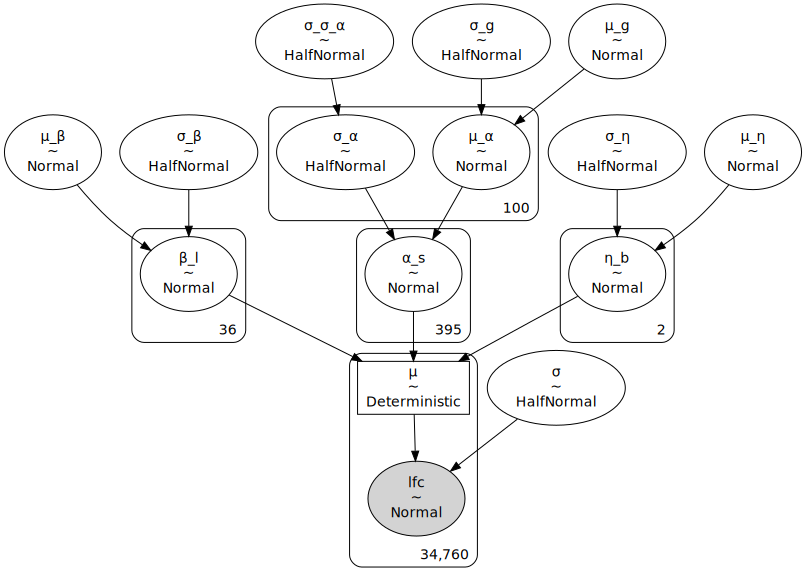

In [8]:
pm.model_to_graphviz(model)

## Fit diagnostics

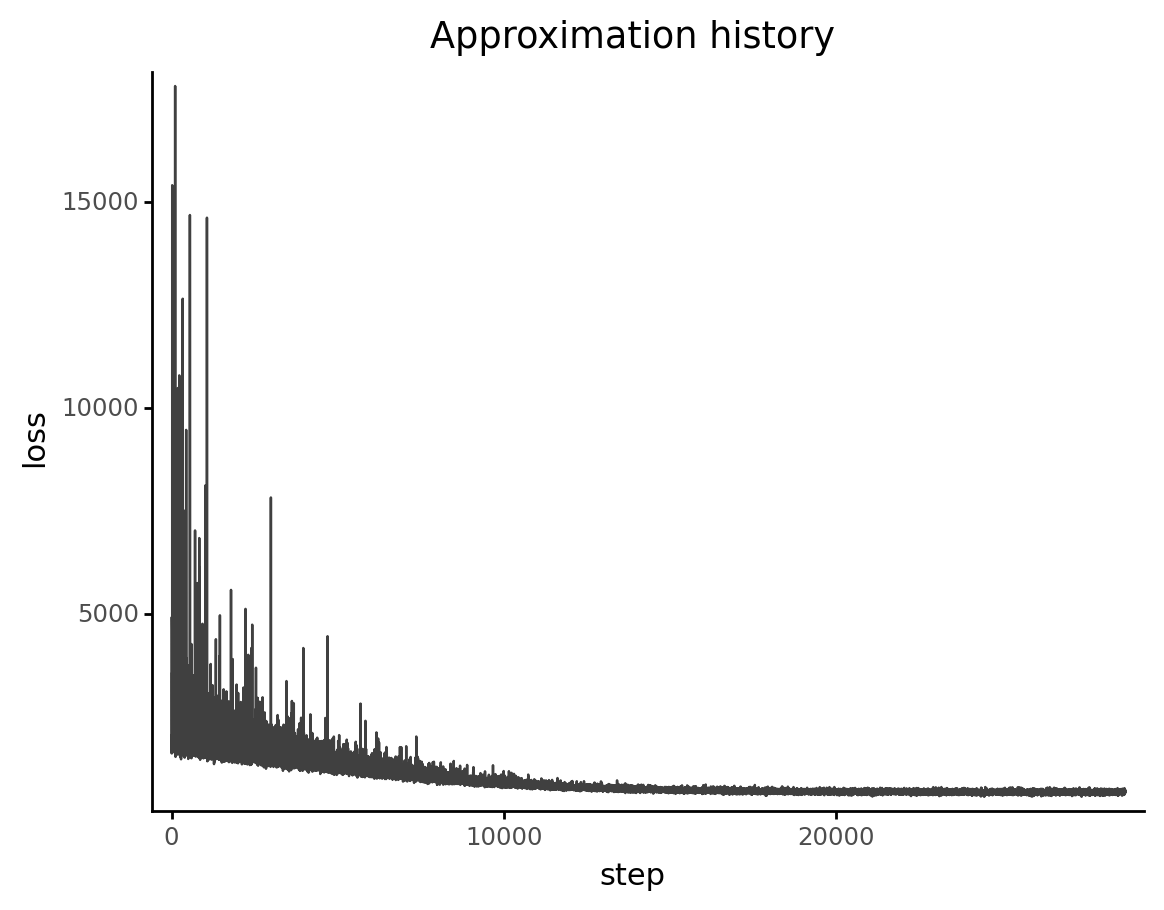

<ggplot: (8775563548124)>

In [9]:
pmanal.plot_vi_hist(model_res["approximation"])

## Model parameters

In [10]:
def check_shape(trace: np.ndarray) -> np.ndarray:
    if len(trace.shape) == 1:
        return trace[:, None]
    return trace


def add_hdi(p: gg.ggplot, values: np.ndarray, color: str) -> gg.ggplot:
    m = np.mean(values)
    hdi = az.hdi(values, hdi_prob=0.89).flatten()
    p = (
        p
        + gg.geom_vline(xintercept=m, color=color)
        + gg.geom_vline(xintercept=hdi, color=color, linetype="--")
    )
    return p


def variable_distribution_plot(var, trace: np.ndarray, max_plot=20000) -> gg.ggplot:
    trace = check_shape(trace)

    # Sample 25% of the trace.
    d = pd.DataFrame(trace).melt().assign(variable=lambda d: d.variable.astype("str"))
    d_summaries = d.groupby(["variable"])["value"].mean().reset_index(drop=False)

    if d.shape[0] > max_plot:
        d = d.sample(n=max_plot)
    else:
        d = d.sample(frac=0.2)

    p = (
        gg.ggplot(d, gg.aes(x="value"))
        + gg.geom_density(alpha=0.1)
        + gg.geom_vline(xintercept=0, color="black", size=0.7, alpha=0.7, linetype="--")
        + gg.scale_x_continuous(expand=(0, 0))
        + gg.scale_y_continuous(expand=(0, 0, 0.02, 0))
        + gg.theme(legend_position="none", figure_size=(6.5, 3))
        + gg.labs(x="posterior", y="density", title=f"Posterior distirbution of {var}")
    )

    c = SeabornColor.blue

    if len(d_summaries) > 1:
        p = p + gg.geom_rug(
            data=d_summaries, sides="b", alpha=0.5, color=c, length=0.08
        )
    else:
        p = add_hdi(p, trace.flatten(), color=c)

    return p

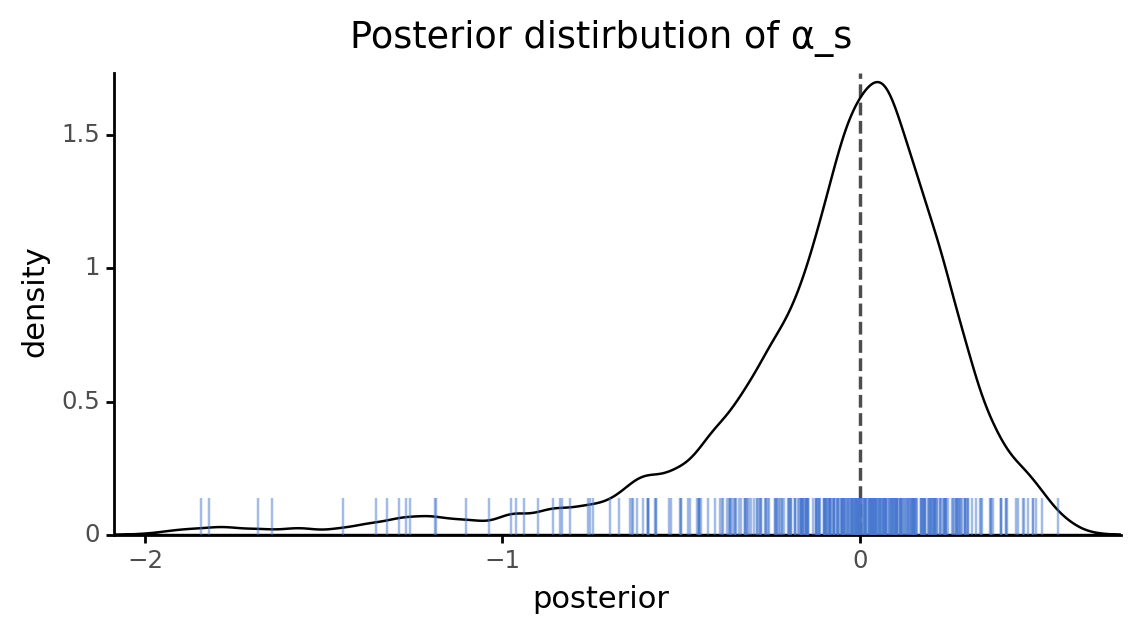

<ggplot: (8775463838952)>


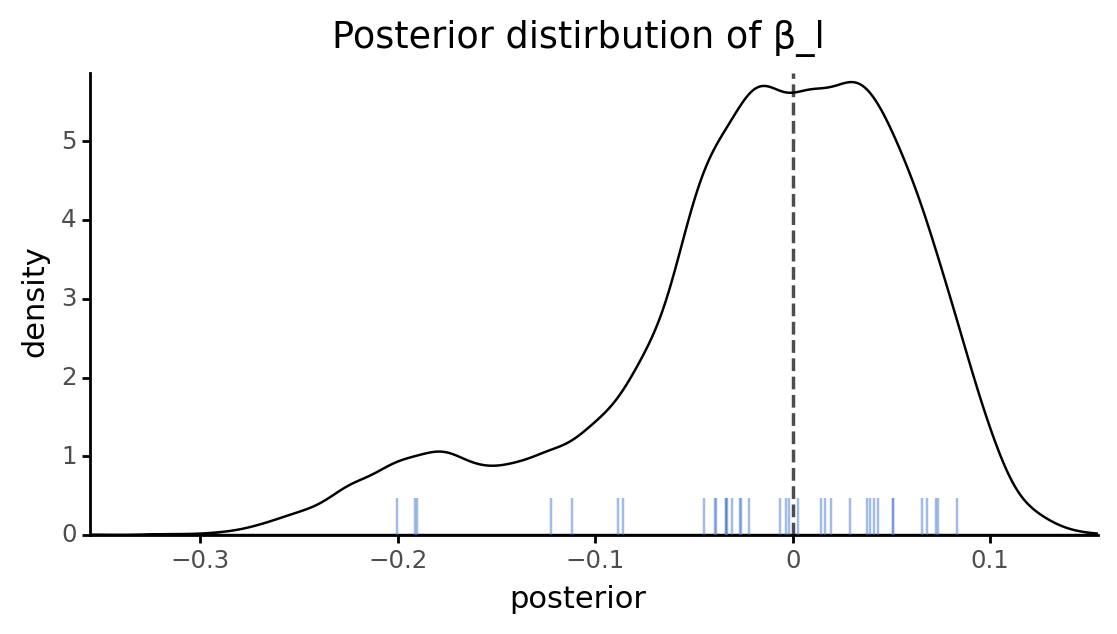

<ggplot: (8775462227423)>


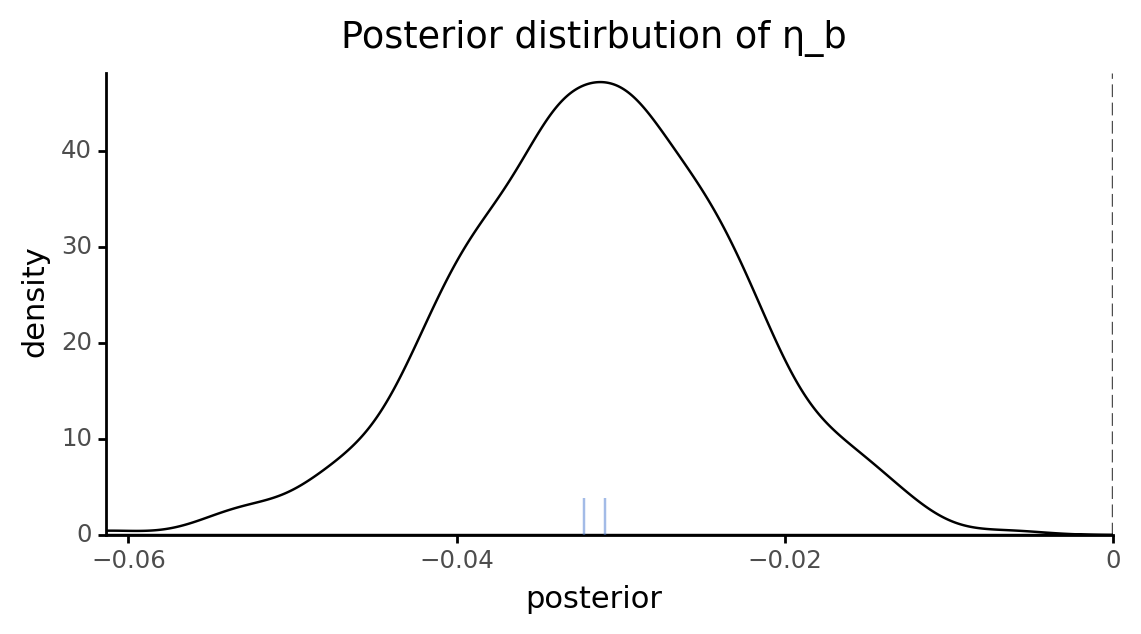

<ggplot: (8775462407458)>


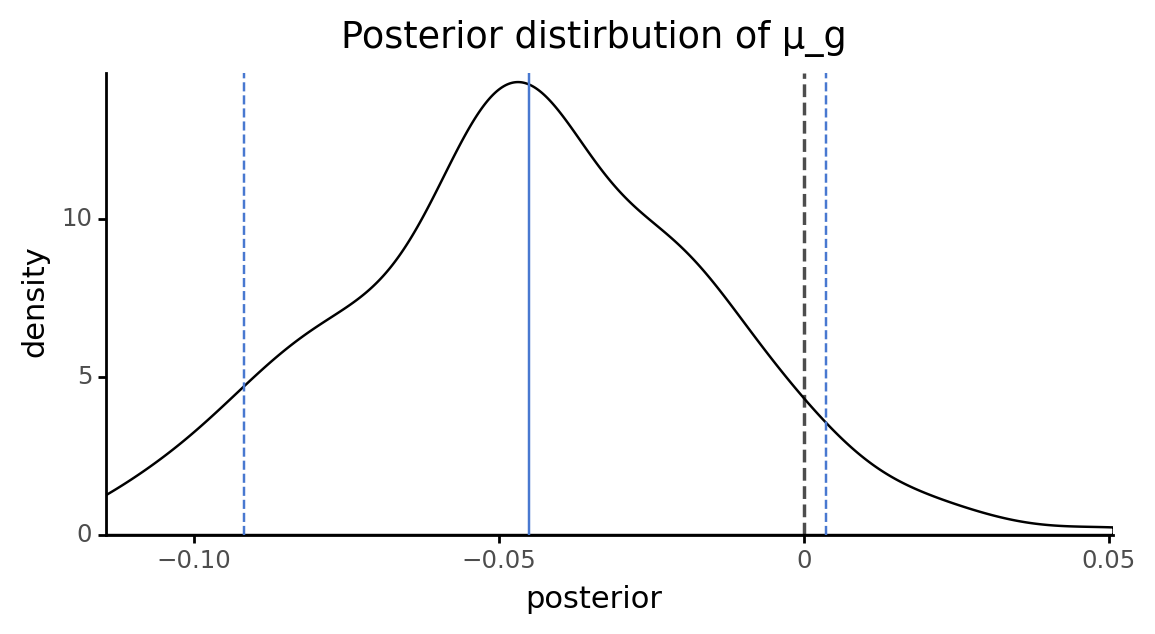

<ggplot: (8775462593148)>


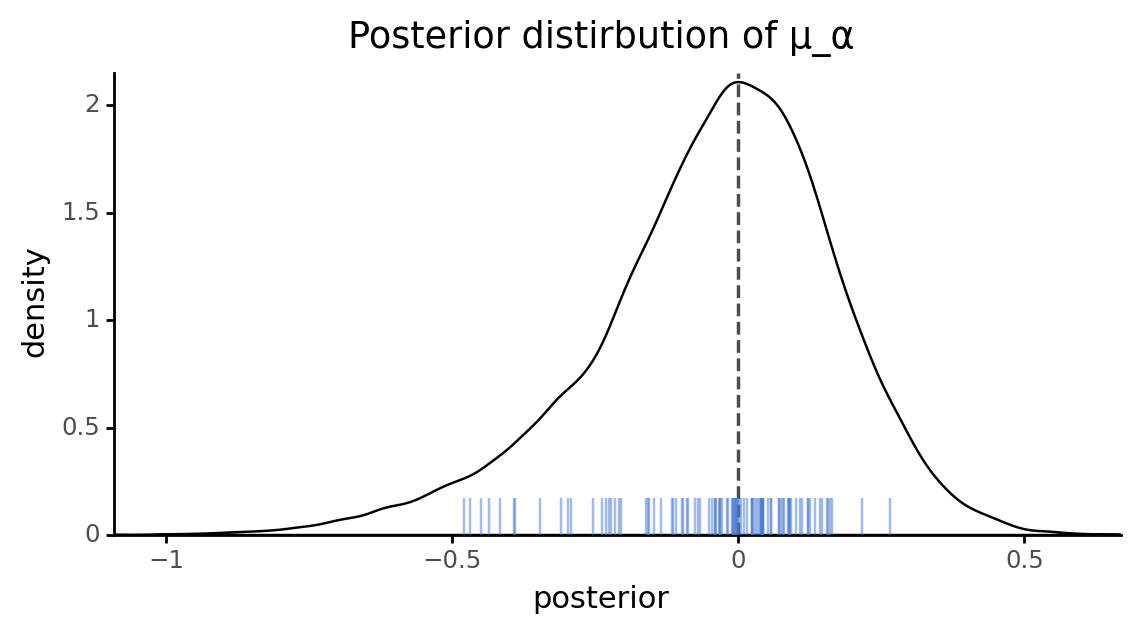

<ggplot: (8775462565084)>


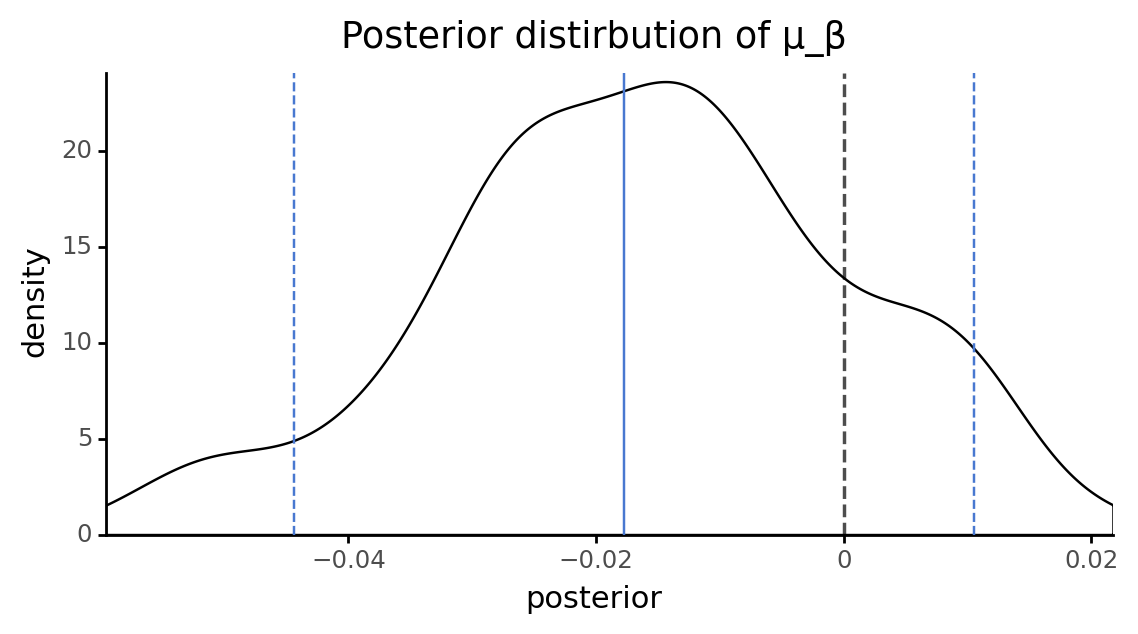

<ggplot: (8775462504120)>


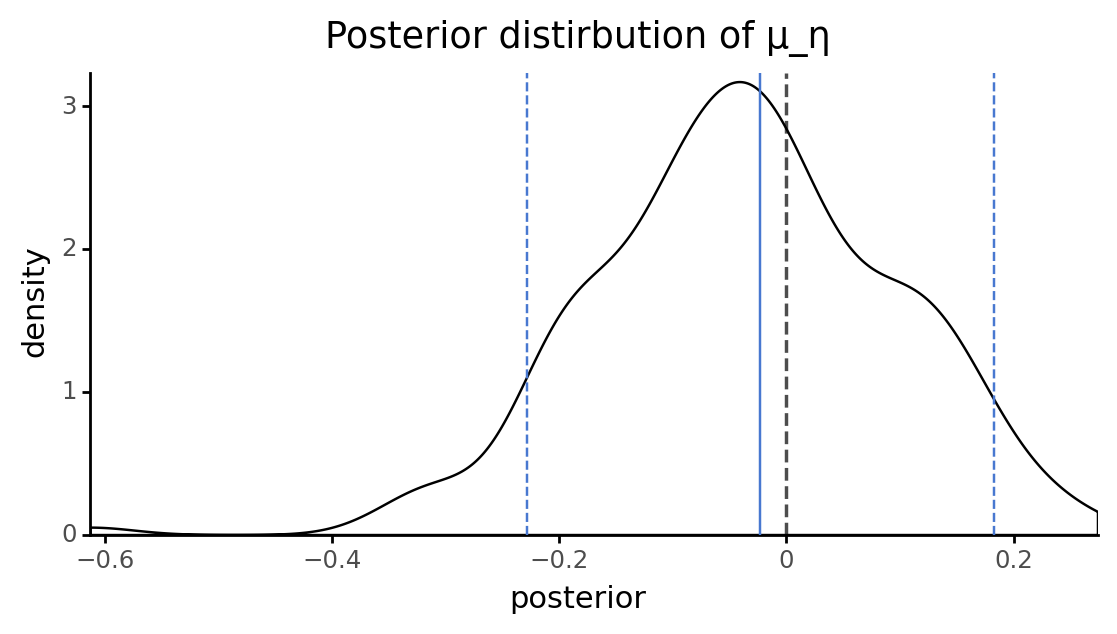

<ggplot: (8775463811901)>


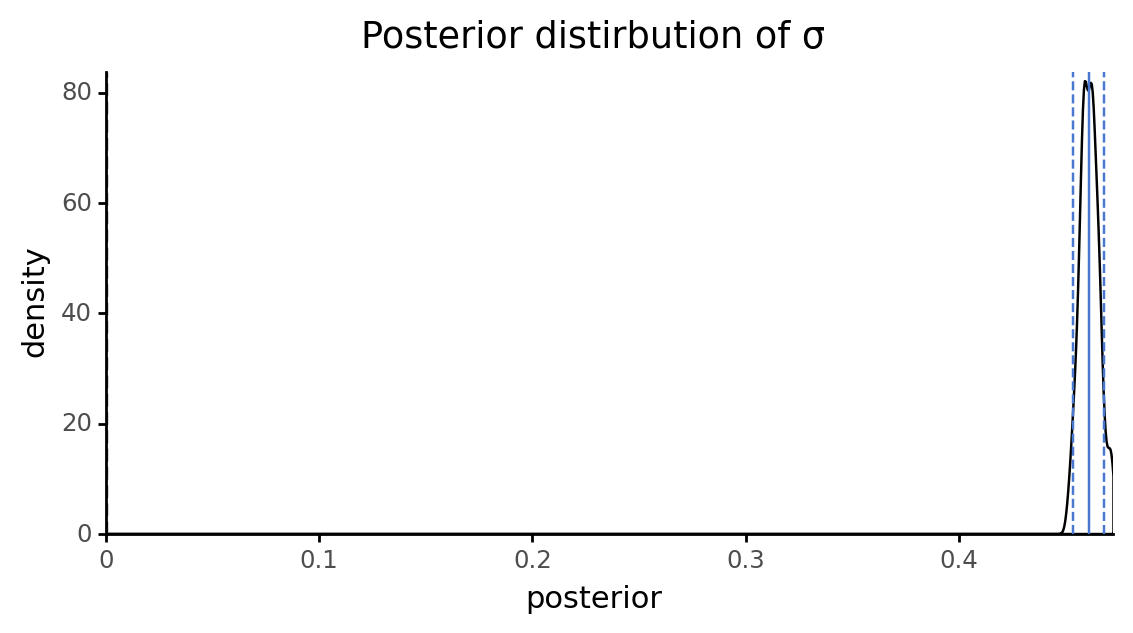

<ggplot: (8775462625907)>


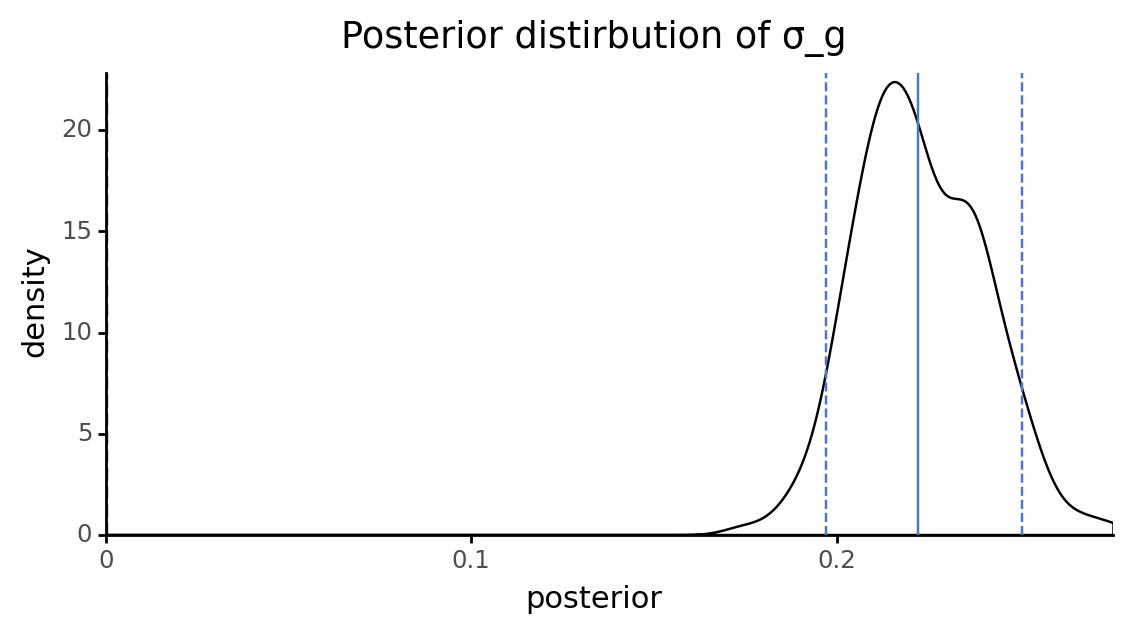

<ggplot: (8775462215958)>


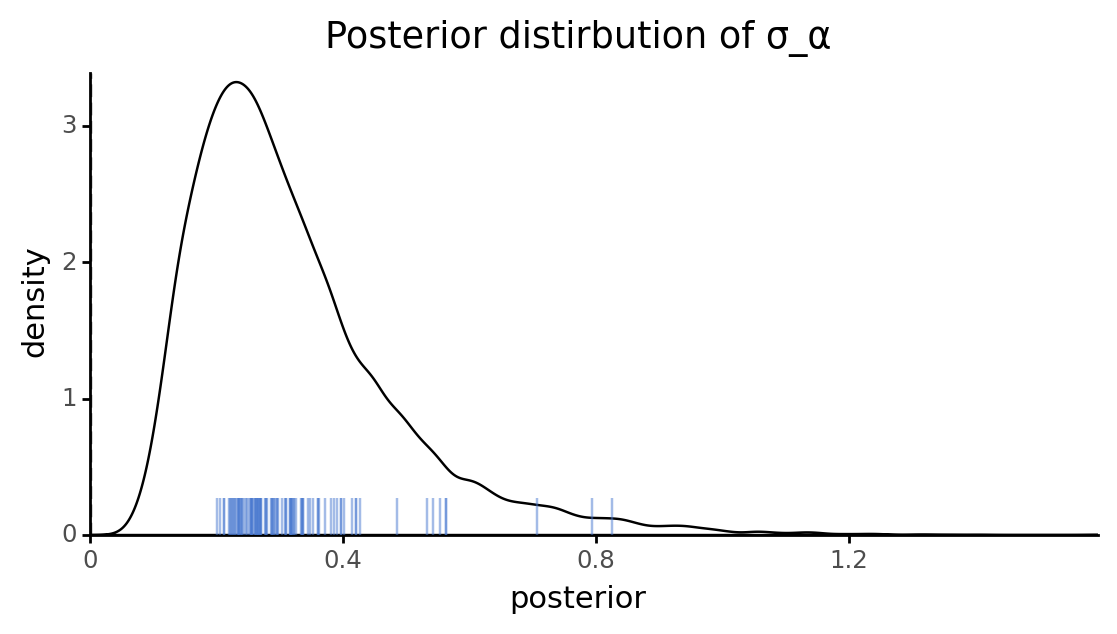

<ggplot: (8775462209049)>


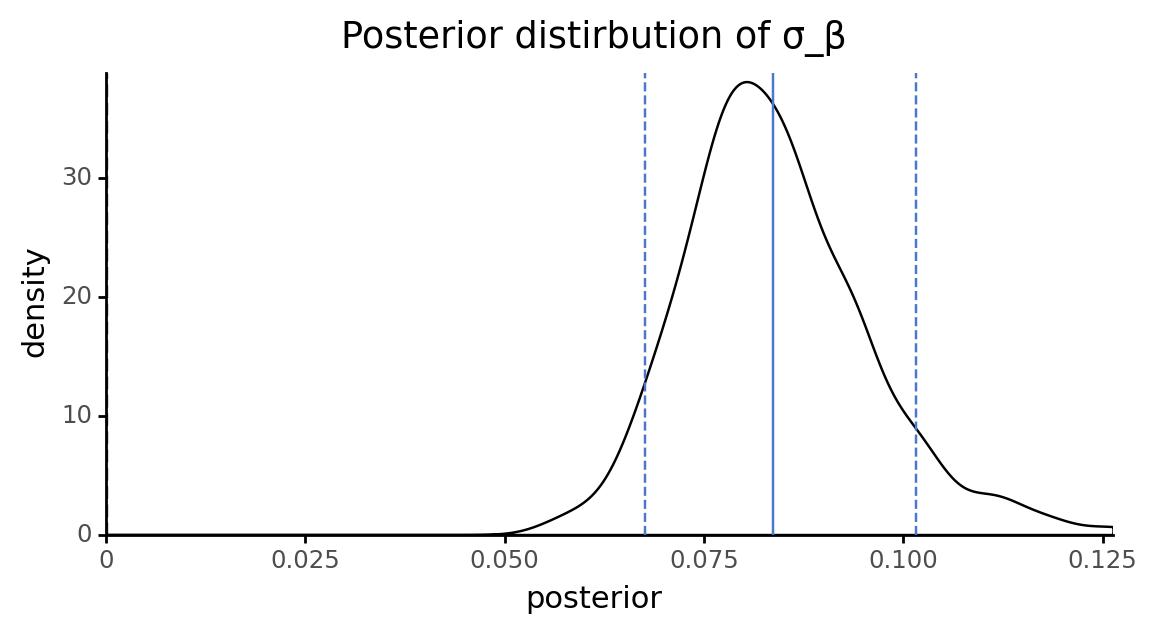

<ggplot: (8775462343979)>


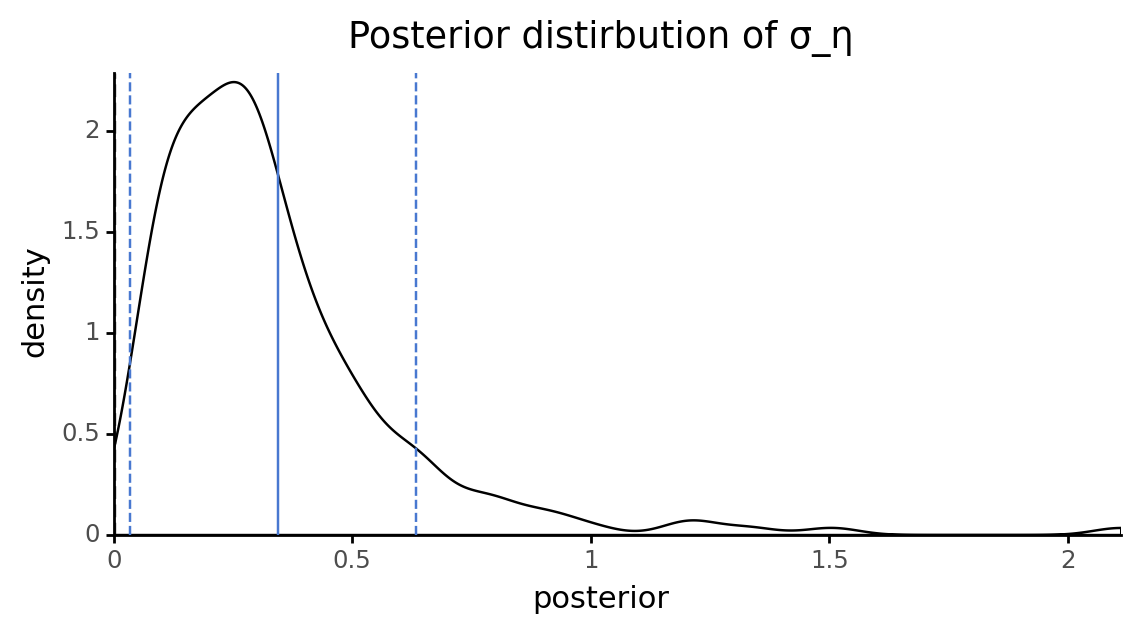

<ggplot: (8775462345454)>


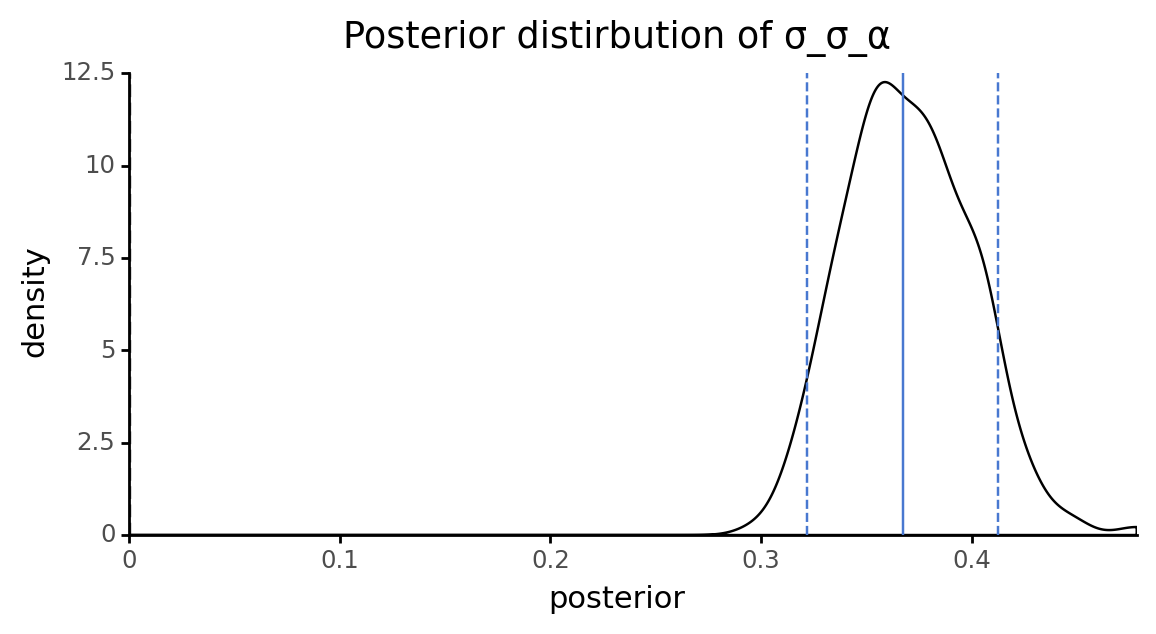

<ggplot: (8775463695339)>


In [11]:
vars_to_inspect = model_res["trace"].varnames
vars_to_inspect = [v for v in vars_to_inspect if not "log" in v]
vars_to_inspect.sort()

for var in vars_to_inspect:
    trace = model_res["trace"][var]
    if len(trace.shape) > 1 and trace.shape[1] == data.shape[0]:
        # Do not plot the final deterministic mean (usually "μ").
        continue
    print(variable_distribution_plot(var, model_res["trace"][var]))

## Model predicitons

In [12]:
predictions = model_res["posterior_predictive"]
pred_summary = pmanal.summarize_posterior_predictions(
    predictions["lfc"],
    merge_with=data,
    calc_error=True,
    observed_y="lfc",
)
pred_summary.head()

/n/data2/dfci/cancerbio/haigis/Cook/speclet/.snakemake/conda/f4a519a1/lib/python3.9/site-packages/arviz/stats/stats.py:456: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions


,pred_mean,pred_hdi_low,pred_hdi_high,sgrna,replicate_id,lfc,pdna_batch,passes_qc,depmap_id,primary_or_metastasis,...,variant_classification,is_deleterious,is_tcga_hotspot,is_cosmic_hotspot,mutated_at_guide_location,rna_expr,log2_cn,z_log2_cn,is_mutated,error
0,-0.178218,-0.897320,0.547094,CCACCCACAGACGCTCAGCA,ls513-311cas9_repa_p6_batch2,0.029491,2,True,ACH-000007,Primary,...,NaN,NaN,NaN,NaN,False,1.480265,1.861144,1.386218,0,0.207709
1,-0.135541,-0.901338,0.600710,CCACCCACAGACGCTCAGCA,ls513-311cas9_repb_p6_batch2,0.426017,2,True,ACH-000007,Primary,...,NaN,NaN,NaN,NaN,False,1.480265,1.861144,1.386218,0,0.561558
2,-0.081253,-0.876622,0.571168,CCACCCACAGACGCTCAGCA,c2bbe1-311cas9 rep a p5_batch3,0.008626,3,True,ACH-000009,Primary,...,NaN,NaN,NaN,NaN,False,0.695994,1.375470,-0.234394,0,0.089879
3,-0.047154,-0.811400,0.690816,CCACCCACAGACGCTCAGCA,c2bbe1-311cas9 rep b p5_batch3,0.280821,3,True,ACH-000009,Primary,...,NaN,NaN,NaN,NaN,False,0.695994,1.375470,-0.234394,0,0.327976
4,-0.058682,-0.776751,0.657707,CCACCCACAGACGCTCAGCA,c2bbe1-311cas9 rep c p5_batch3,0.239815,3,True,ACH-000009,Primary,...,NaN,NaN,NaN,NaN,False,0.695994,1.375470,-0.234394,0,0.298497


<AxesSubplot:>

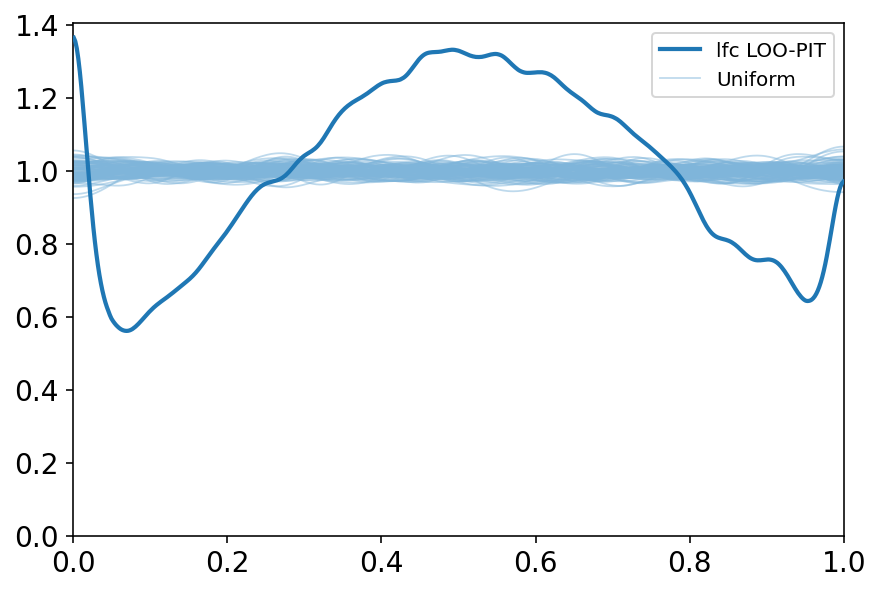

In [13]:
az.plot_loo_pit(model_az, y="lfc");

In [14]:
model_loo = az.loo(model_az, pointwise=True)
print(model_loo)

Computed from 1000 by 34760 log-likelihood matrix

         Estimate       SE
elpd_loo -22806.11   205.65
p_loo     1067.75        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     34736   99.9%
 (0.5, 0.7]   (ok)          23    0.1%
   (0.7, 1]   (bad)          1    0.0%
   (1, Inf)   (very bad)     0    0.0%



/n/data2/dfci/cancerbio/haigis/Cook/speclet/.snakemake/conda/f4a519a1/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:ylabel='Density'>

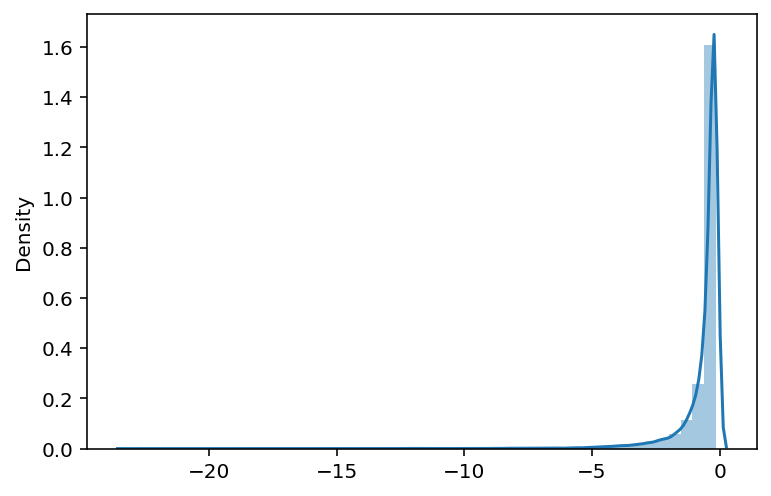

In [15]:
sns.distplot(model_loo.loo_i.values);

In [16]:
pred_summary["loo"] = model_loo.loo_i.values

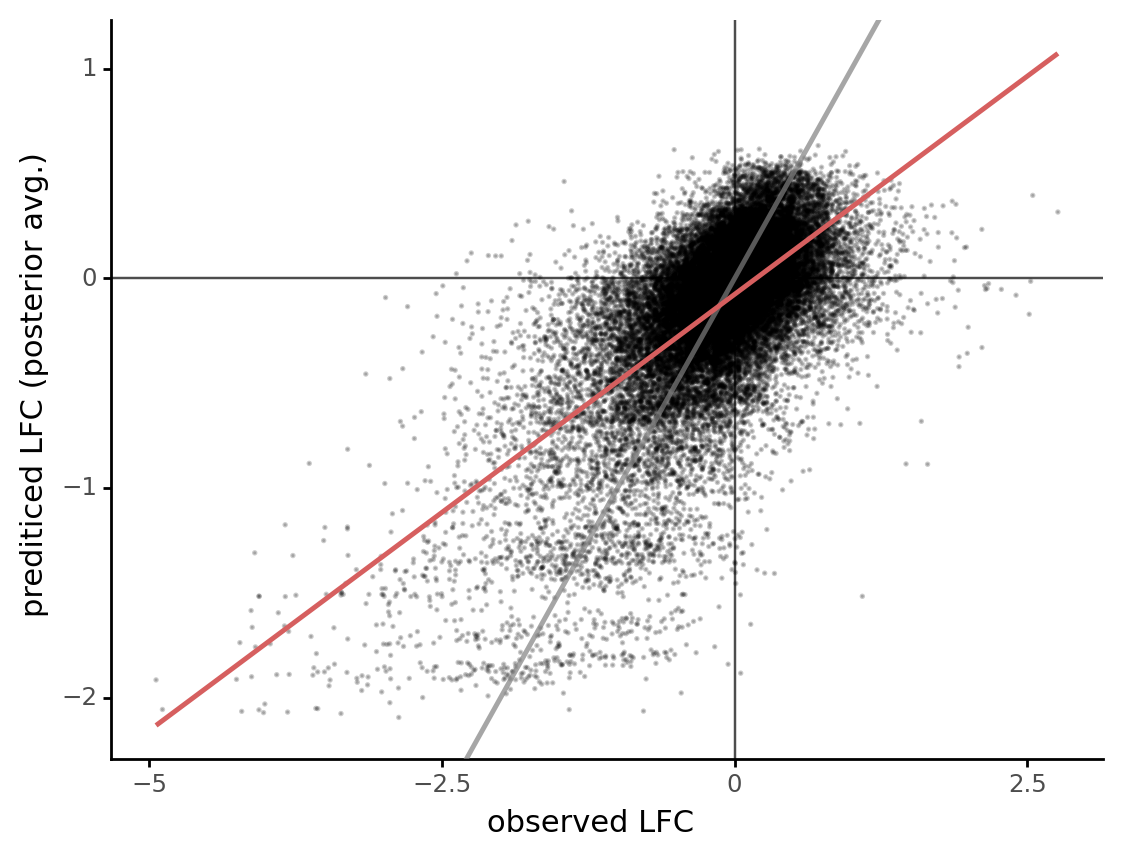

<ggplot: (8775463794285)>

In [17]:
(
    gg.ggplot(pred_summary, gg.aes(x="lfc", y="pred_mean"))
    + gg.geom_hline(yintercept=0, size=0.5, alpha=0.7)
    + gg.geom_vline(xintercept=0, size=0.5, alpha=0.7)
    + gg.geom_point(size=0.1, alpha=0.2)
    + gg.geom_abline(slope=1, intercept=0, size=1, alpha=0.7, color="grey")
    + gg.geom_smooth(method="glm", color=SeabornColor.red, size=1, alpha=0.7, se=False)
    + gg.labs(x="observed LFC", y="prediticed LFC (posterior avg.)")
)

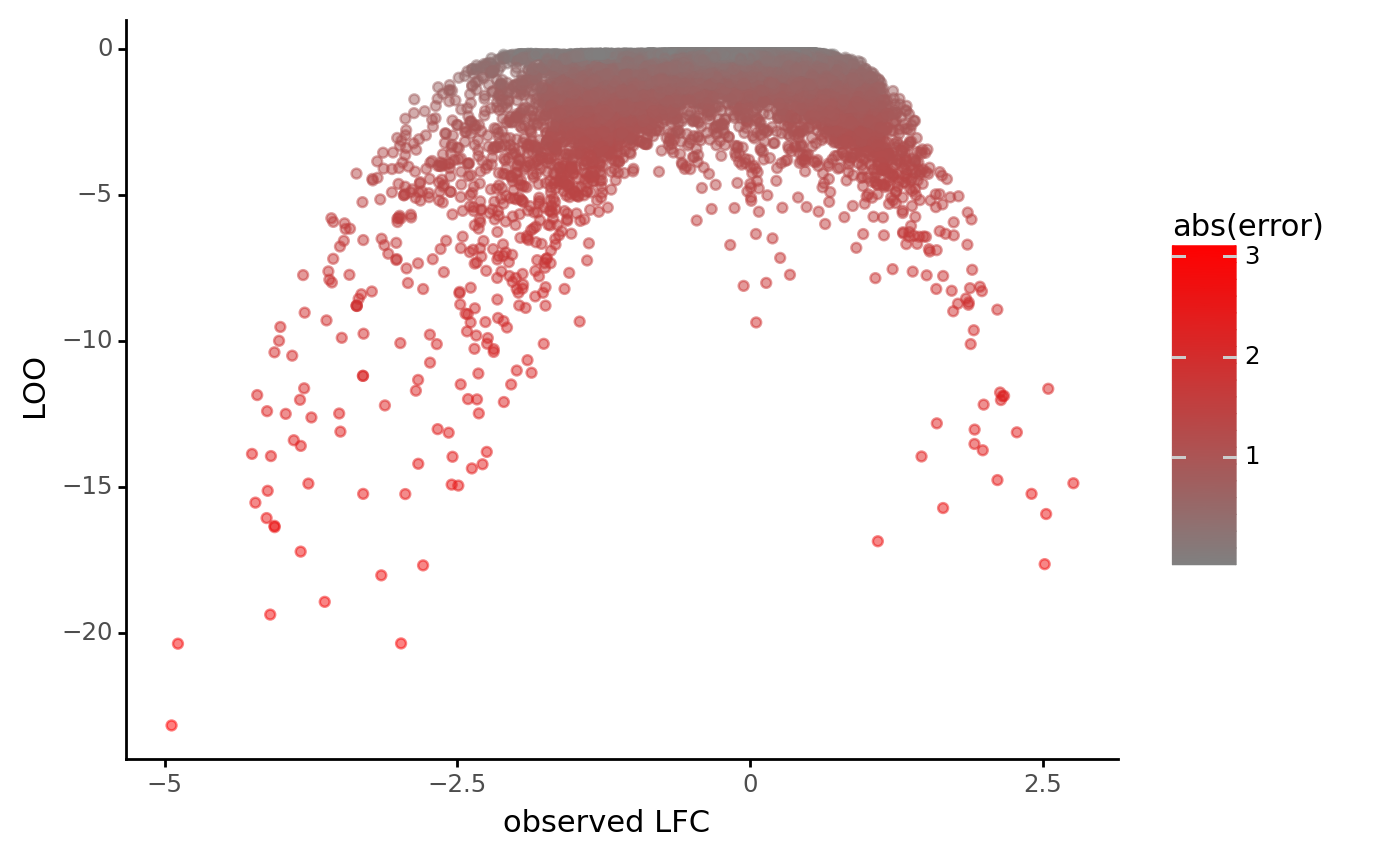

<ggplot: (8775462799231)>

In [18]:
(
    gg.ggplot(pred_summary, gg.aes(x="lfc", y="loo"))
    + gg.geom_point(gg.aes(color="np.abs(error)"), alpha=0.5)
    + gg.scale_color_gradient(low="grey", high="red")
    + gg.theme()
    + gg.labs(x="observed LFC", y="LOO", color="abs(error)")
)

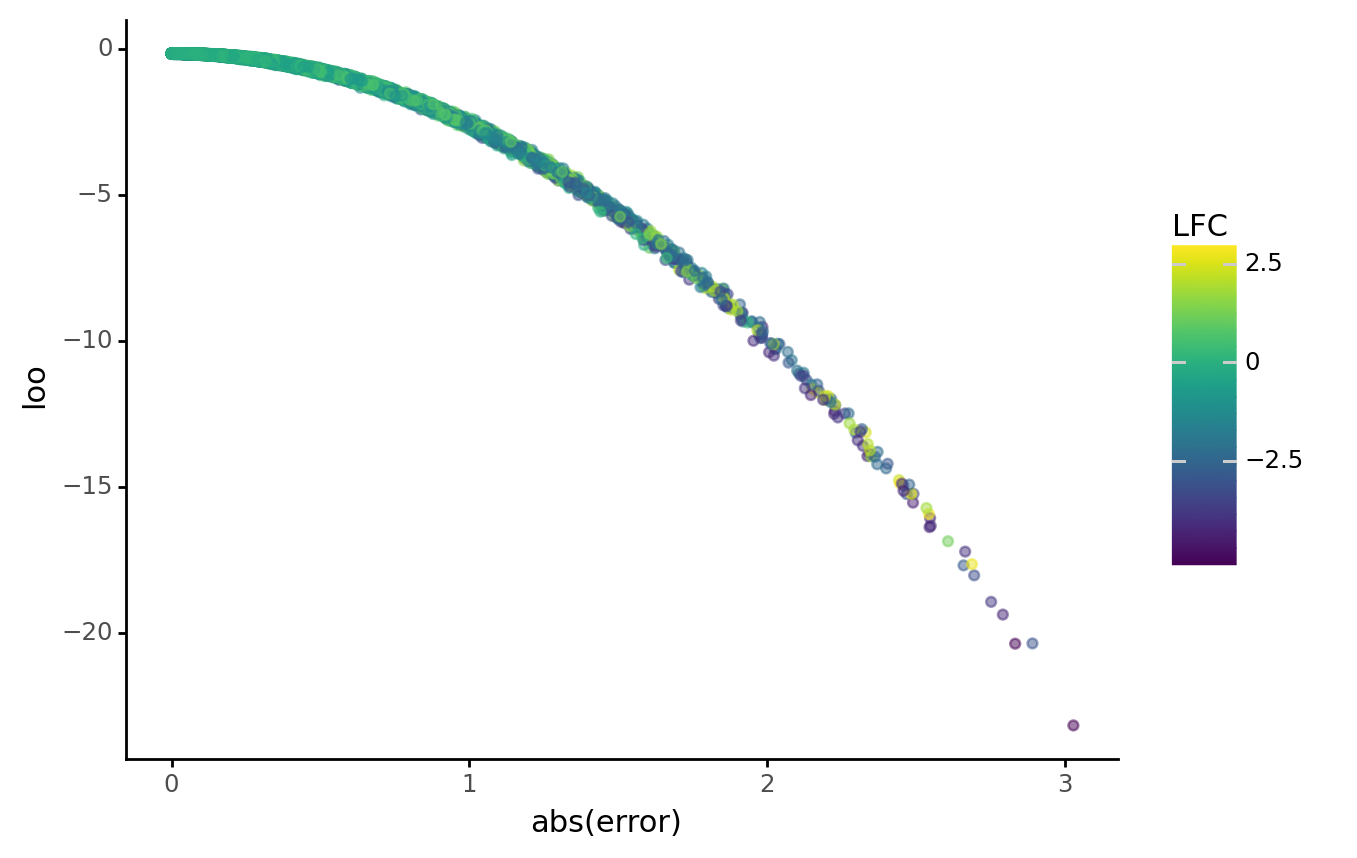

<ggplot: (8775463373168)>

In [19]:
(
    gg.ggplot(pred_summary, gg.aes(x="np.abs(error)", y="loo"))
    + gg.geom_point(gg.aes(color="lfc"), alpha=0.5)
    + gg.labs(x="abs(error)", y="loo", color="LFC")
)

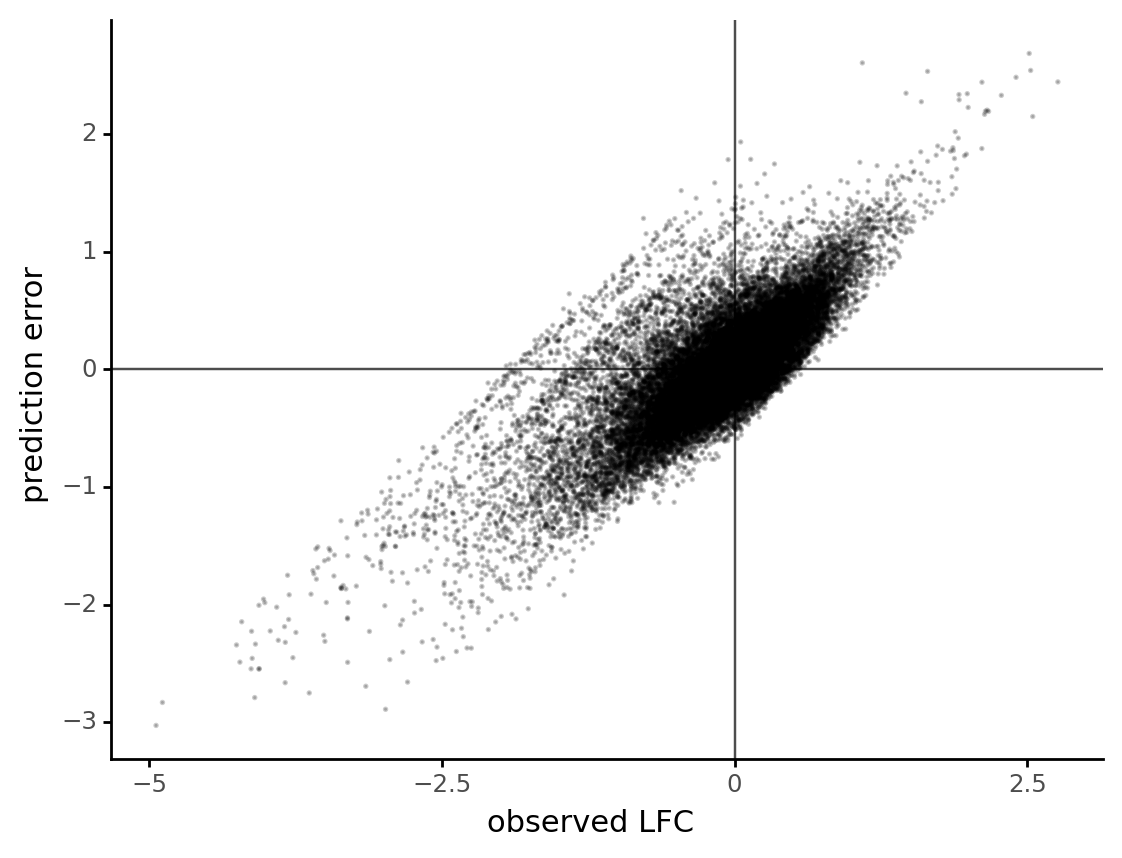

<ggplot: (8775463373081)>

In [20]:
(
    gg.ggplot(pred_summary, gg.aes(x="lfc", y="error"))
    + gg.geom_hline(yintercept=0, size=0.5, alpha=0.7)
    + gg.geom_vline(xintercept=0, size=0.5, alpha=0.7)
    + gg.geom_point(size=0.1, alpha=0.2)
    + gg.labs(x="observed LFC", y="prediction error")
)

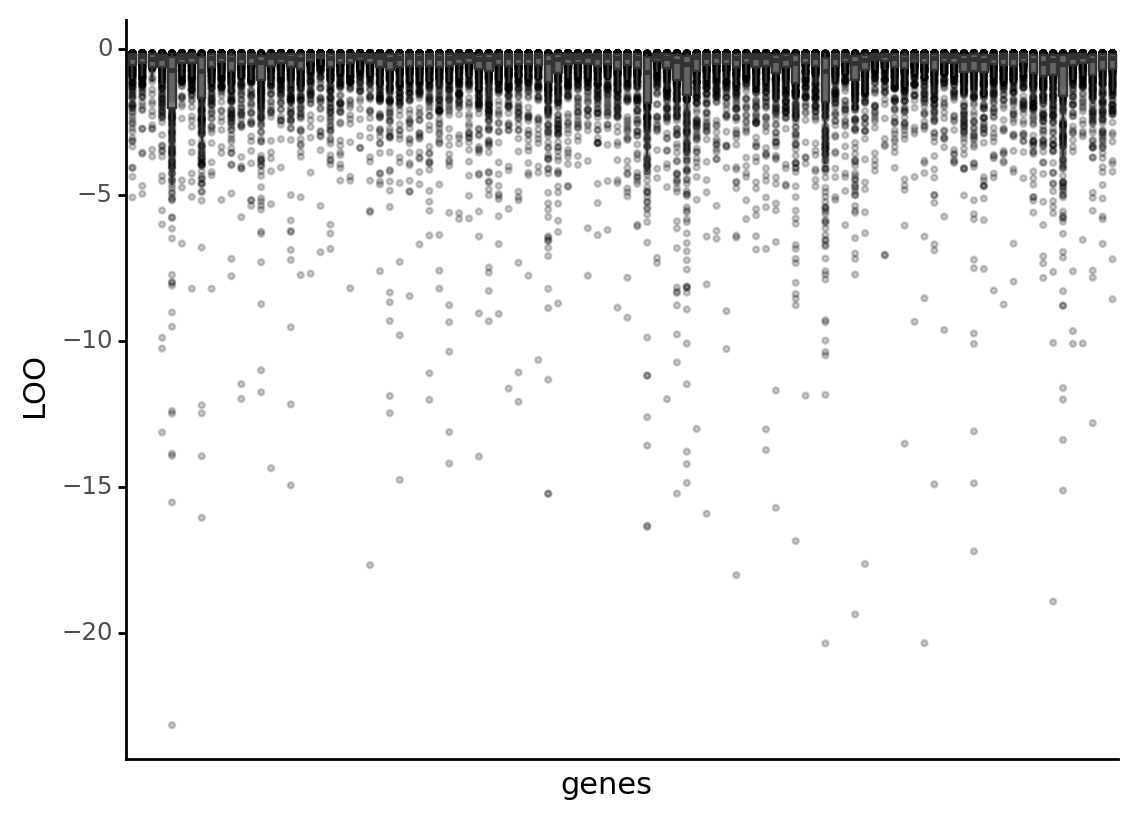

<ggplot: (8775463040359)>

In [21]:
(
    gg.ggplot(pred_summary, gg.aes(x="hugo_symbol", y="loo"))
    + gg.geom_point(alpha=0.2, size=0.7)
    + gg.geom_boxplot(outlier_alpha=0, alpha=0.4)
    + gg.theme(axis_text_x=gg.element_blank(), axis_ticks_major_x=gg.element_blank())
    + gg.labs(x="genes", y="LOO")
)

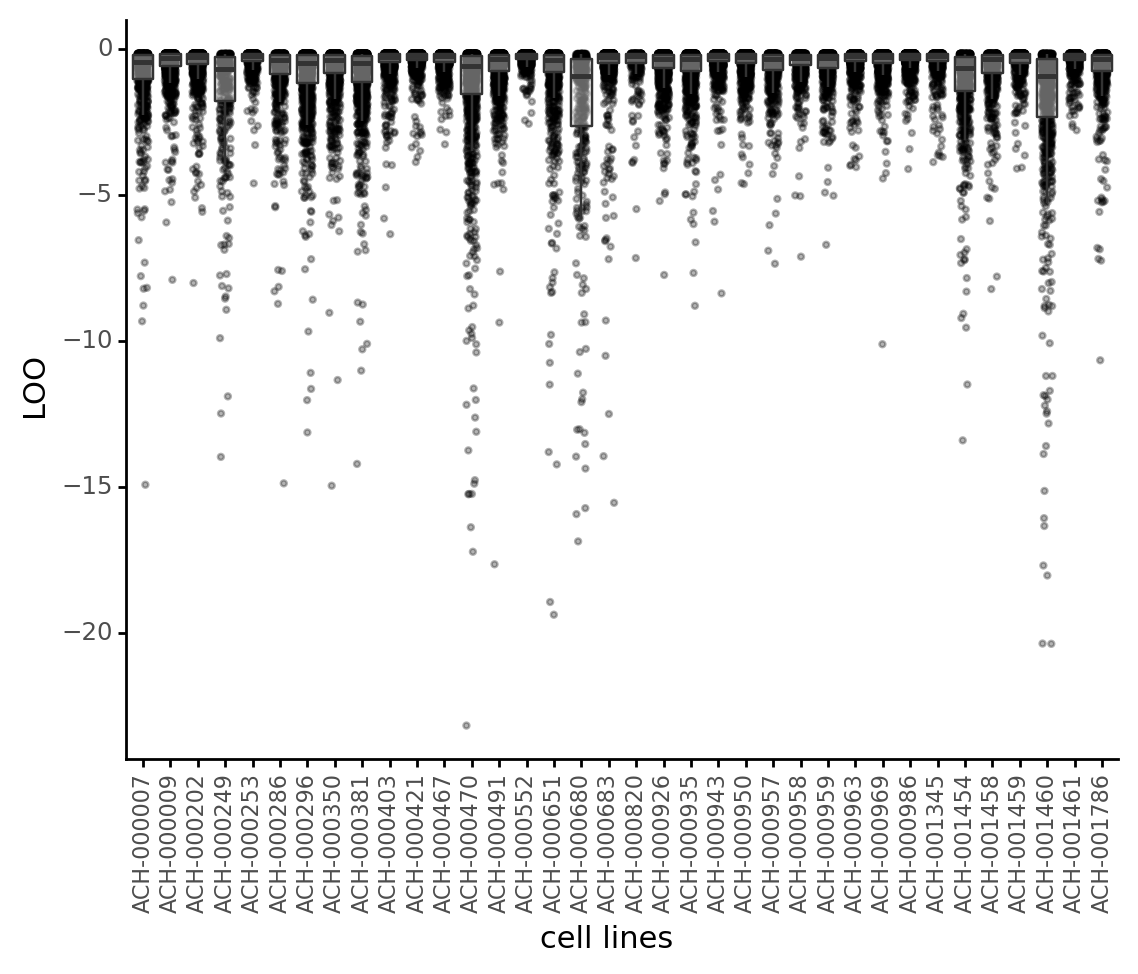

<ggplot: (8775463373918)>

In [22]:
(
    gg.ggplot(pred_summary, gg.aes(x="depmap_id", y="loo"))
    + gg.geom_jitter(width=0.2, alpha=0.3, size=0.7)
    + gg.geom_boxplot(outlier_alpha=0, alpha=0.4)
    + gg.theme(
        axis_text_x=gg.element_text(angle=90, size=8),
    )
    + gg.labs(x="cell lines", y="LOO")
)

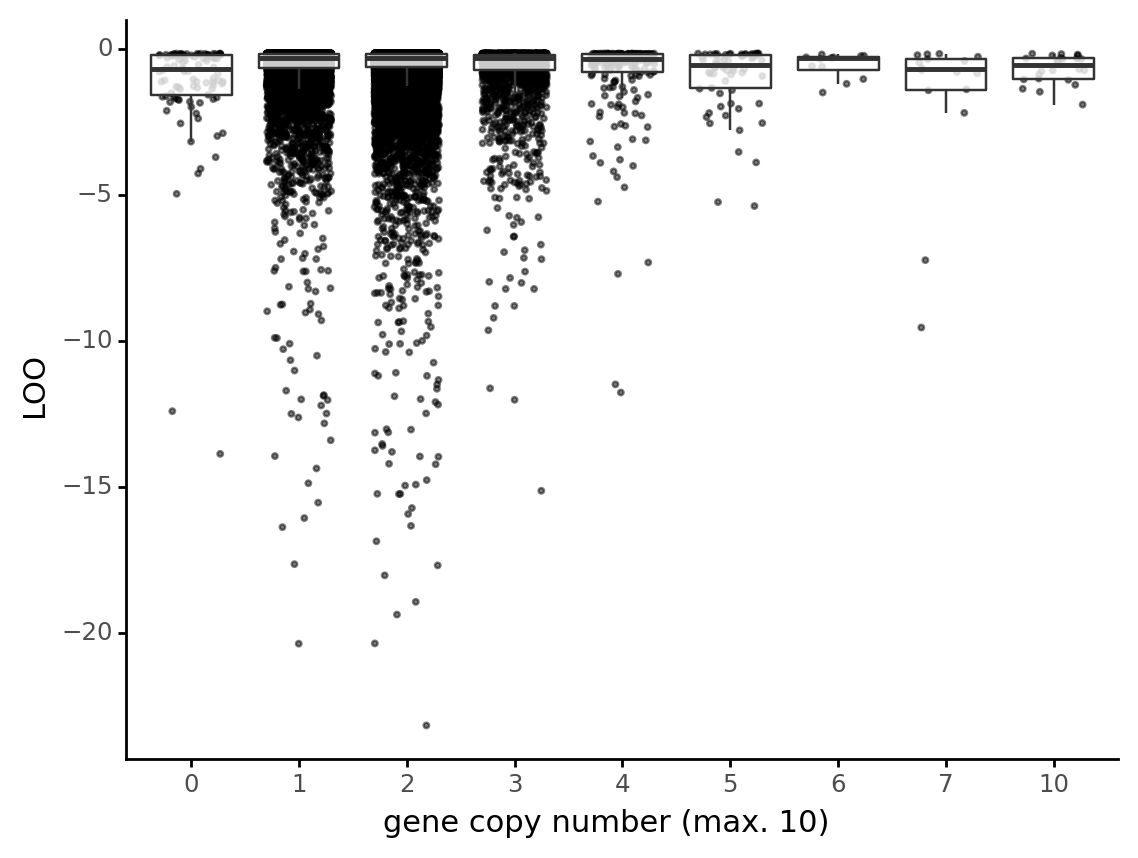

<ggplot: (8775462798318)>

In [23]:
# Remove samples without gene CN data.
ppc_df_no_missing = pred_summary.copy()[~pred_summary.gene_cn.isna()]
ppc_df_no_missing["binned_gene_cn"] = [
    np.min([round(x), 10]) for x in ppc_df_no_missing.gene_cn
]

(
    gg.ggplot(ppc_df_no_missing, gg.aes(x="factor(binned_gene_cn)", y="loo"))
    + gg.geom_jitter(size=0.6, alpha=0.5, width=0.3)
    + gg.geom_boxplot(outlier_alpha=0, alpha=0.8)
    + gg.labs(x="gene copy number (max. 10)", y="LOO")
)

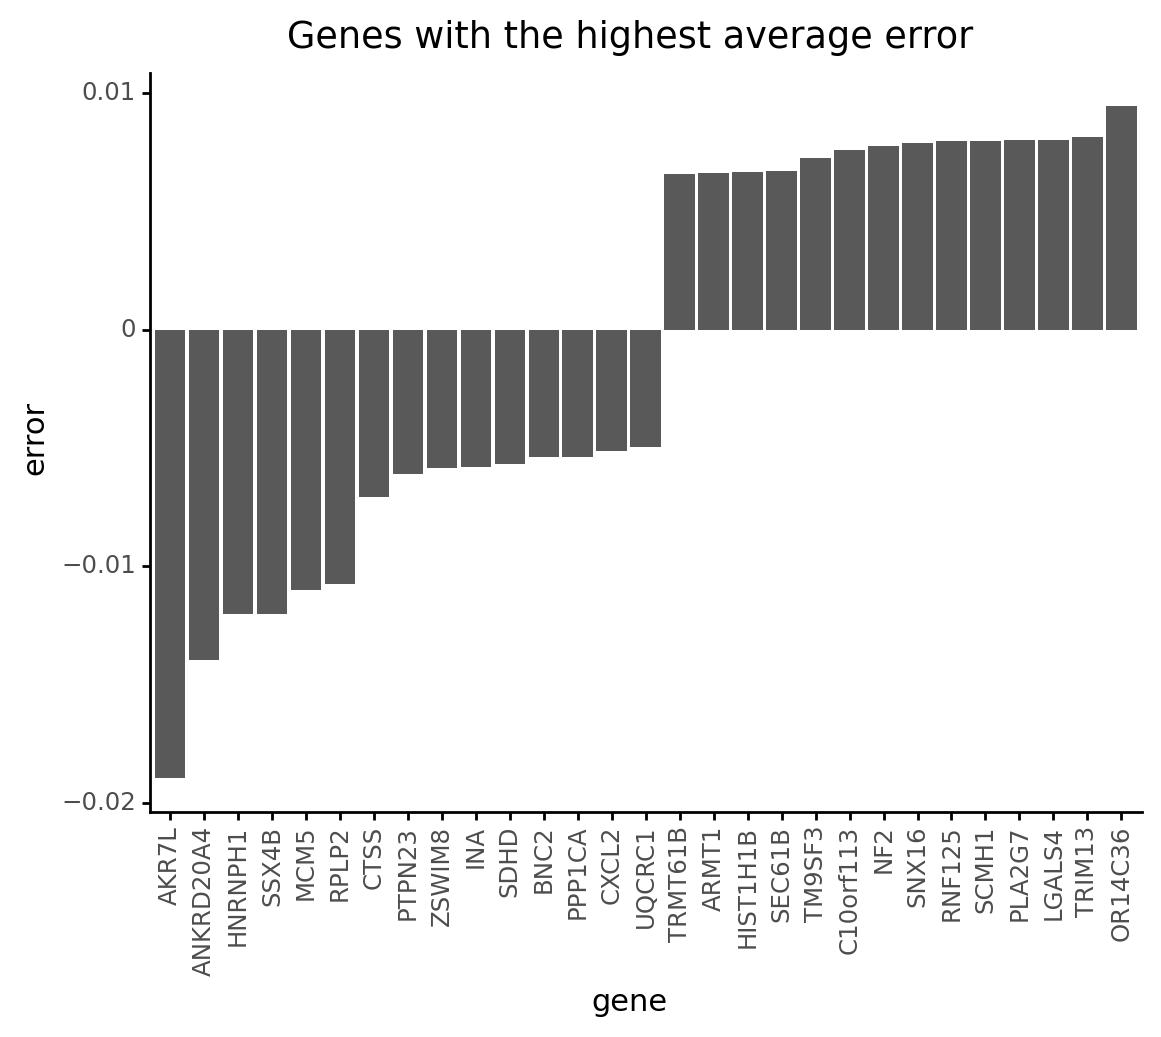

<ggplot: (8775463033164)>

In [24]:
gene_error = (
    pred_summary.groupby(["hugo_symbol"])["error"]
    .agg([np.mean, np.std])
    .reset_index(drop=False)
    .sort_values(["mean"])
    .reset_index(drop=True)
    .assign(
        hugo_symbol=lambda d: pd.Categorical(
            d.hugo_symbol.astype(str),
            categories=d.hugo_symbol.astype(str),
            ordered=True,
        )
    )
)

n_genes = 15

(
    gg.ggplot(
        gene_error.iloc[list(range(n_genes)) + list(range(-n_genes, -1))],
        gg.aes(x="hugo_symbol", y="mean"),
    )
    + gg.geom_col()
    + gg.theme(axis_text_x=gg.element_text(angle=90))
    + gg.labs(x="gene", y="error", title="Genes with the highest average error")
)

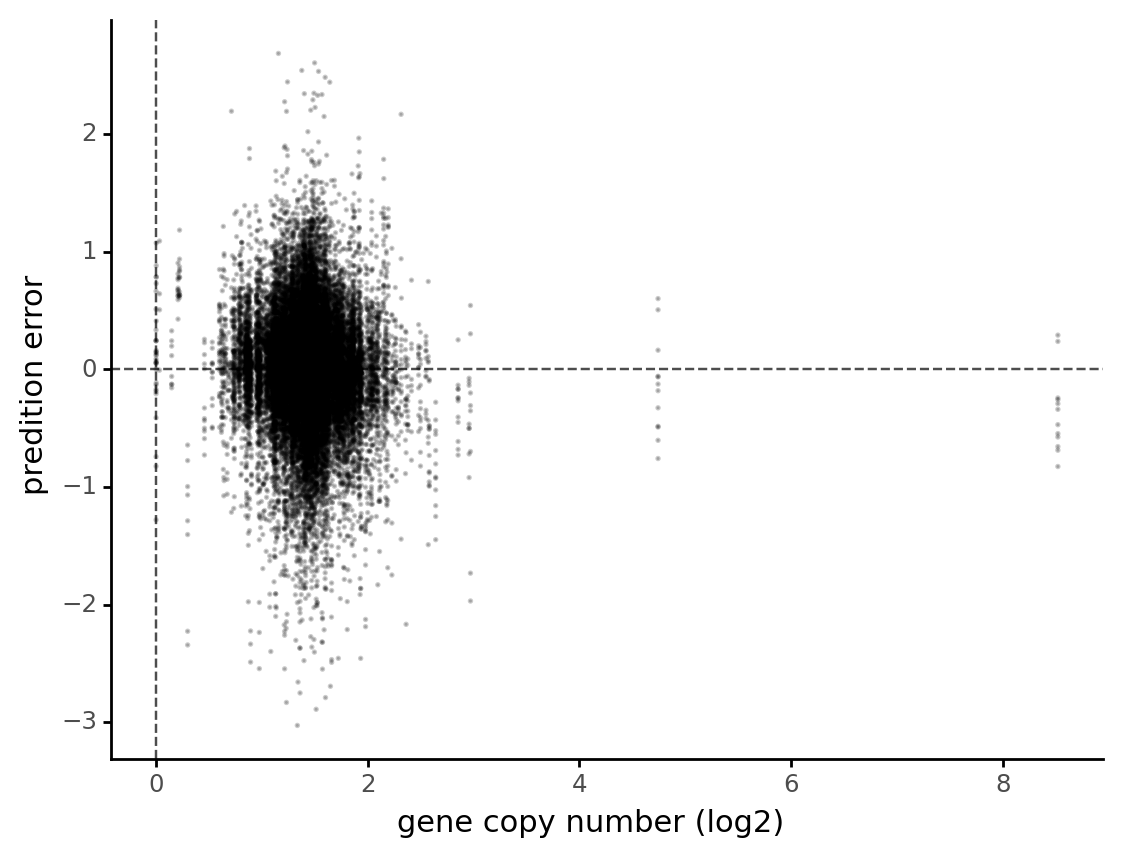

<ggplot: (8775459799507)>

In [25]:
(
    gg.ggplot(pred_summary, gg.aes(x="log2_cn", y="error"))
    + gg.geom_hline(yintercept=0, size=0.5, alpha=0.7, linetype="--")
    + gg.geom_vline(xintercept=0, size=0.5, alpha=0.7, linetype="--")
    + gg.geom_point(size=0.1, alpha=0.2)
    + gg.labs(x="gene copy number (log2)", y="predition error")
)

---

In [26]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 3.56 minutes


In [27]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-03-18

Python implementation: CPython
Python version       : 3.9.2
IPython version      : 7.21.0

Compiler    : GCC 9.3.0
OS          : Linux
Release     : 3.10.0-1062.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 28
Architecture: 64bit

Hostname: compute-e-16-233.o2.rc.hms.harvard.edu

Git branch: ppc-loocv

arviz     : 0.11.2
pandas    : 1.2.3
plotnine  : 0.7.1
seaborn   : 0.11.1
pymc3     : 3.11.1
matplotlib: 3.3.4
numpy     : 1.20.1

